In [5]:
import dataset_models
import imp
imp.reload(dataset_models)

import pandas as pd
from dataset_models import Umi, session, db, Dataset, UmiGoTerm, UmiGeneId, GoTerm, NcbiGene, Segment

#sql boilerplate
rsq = pd.read_sql_query
sq = session.query

In [6]:
from sqlalchemy import func

In [7]:
# example of a joined query which lists UMI counts
# for each GO term matching a particular function
# stmt = session.query(
#    UmiGoTerm.go_id, func.count('*').label('umi_count')
# ).group_by(UmiGoTerm.go_id).subquery()

# for u, count in session.query(GoTerm, stmt.c.umi_count)\
#             .filter(GoTerm.go_name.ilike("%DNA%"))\
#             .outerjoin(stmt, GoTerm.go_id == stmt.c.go_id)\
#             .order_by(GoTerm.go_id).limit(10):
    
#    print(u.go_name, count)

In [8]:
ncbi_searches = ["dna", "ribo", "nucle", "memb", "mitoc","cytop"]

In [9]:


# example of a joined query which lists UMI counts
# for each GO term matching a particular function
#stmt = session.query(
#   Umi.id, func.count('*').label('umi_count')
#).group_by(Umi.id).subquery()


#this counts ttal numbers of matches of a segment to have a given GO term match
gene_search_umi_counts = pd.DataFrame([  pd.Series({"umi_id":uid,"seg_id":s.id,"term":searchterm})  
                        for searchterm in ncbi_searches 
                        for s,uid in session.query(Segment,Umi.id).join(Umi).join(UmiGeneId).join(NcbiGene)\
                                .filter(NcbiGene.desc.ilike(f"%{searchterm}%")).all() ])



go_search_umi_counts = pd.DataFrame([  pd.Series({"umi_id":uid,"seg_id":s.id,"term":searchterm})  
                        for searchterm in ncbi_searches 
                        for s,uid in session.query(Segment,Umi.id).join(Umi).join(UmiGoTerm).join(GoTerm)\
                                .filter(GoTerm.go_name.ilike(f"%{searchterm}%")).all() ])




In [10]:

seg_counts = pd.read_sql_query(session.query(Umi.seg, func.count(Umi.seg).label("count")).group_by(Umi.seg)\
        .order_by(desc(func.count(Umi.seg))).statement,db, index_col="seg")


In [11]:
seg_umi_umi_gene_counts = gene_search_umi_counts.groupby(["seg_id","term"]).count().unstack()["umi_id"].fillna(0)
seg_umi_umi_go_counts = go_search_umi_counts.groupby(["seg_id","term"]).count().unstack()["umi_id"].fillna(0)

In [12]:
umis = rsq(sq(Umi).statement,db,index_col="id")
segs = rsq(sq(Segment).statement,db,index_col="id")

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

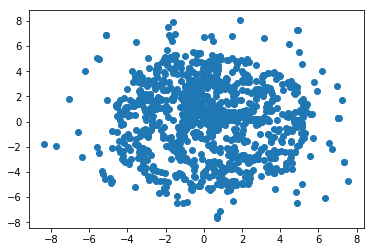

In [14]:
plt.scatter(*[c for c in umis.loc[umis.molecule_type==0][["x","y"]].iloc[::100].values.T])

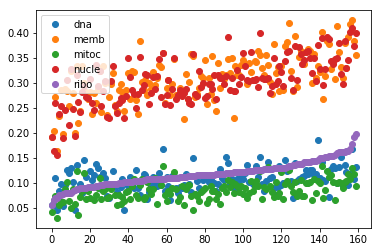

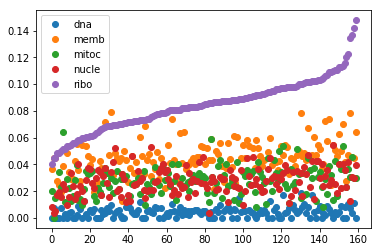

In [15]:

for dataset in [seg_umi_umi_go_counts,seg_umi_umi_gene_counts]:
    f,sub = plt.subplots(1,1)
    ax = sub
    plt.sca(ax)
    
    tests = dataset.iloc[:,1:]
    tests_norm_1 = tests.apply(lambda x: x / seg_counts["count"]).fillna(0)
    ct_gt5 = set(seg_counts.loc[seg_counts["count"] >200].index.values)
    ds1_tests = tests_norm_1.loc[tests_norm_1.index.isin(ct_gt5)]
    
    #ds1_tests2 = ds1_tests.loc[seg_counts.loc[seg_counts["count"] >5].index ]
    ds1_tests_dna = ds1_tests.sort_values("ribo")


    for c in ds1_tests_dna.columns:
        yseries = ds1_tests_dna[c].iloc[::1]
        plt.plot( range(len(yseries)), yseries,"o")

    plt.legend()

In [16]:
session.commit()

In [17]:
sq(Segment.id,  func.count('*').label('umi_count')).group_by(Segment.id).limit(10).all()

[(1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1)]

In [18]:
stmt = session.query(
   Umi.seg, func.count('*').label('umi_count')
).group_by(Umi.seg).subquery()


In [19]:
stmt = session.query(
   Umi.seg, func.count('*').label('umi_count')
).group_by(Umi.seg).subquery()

seg31_counts = rsq( session.query(Segment.id.label("seg_id"), stmt.c.umi_count)\
            .filter(Segment.dsid == 31944625)\
            .join(stmt, Segment.id == stmt.c.seg)\
            .order_by(desc(stmt.c.umi_count)).statement,db,index_col="seg_id")

In [65]:
seg31_withcounts = pd.concat([segs.loc[segs.dsid == 31944625],seg31_counts],axis = 1)
selected_segs=seg31_withcounts.loc[(seg31_withcounts.umi_count > 100) & (seg31_withcounts.umi_count <500)].iloc[:100]
selected_umis = umis.loc[umis.seg.isin(selected_segs.index)].copy()



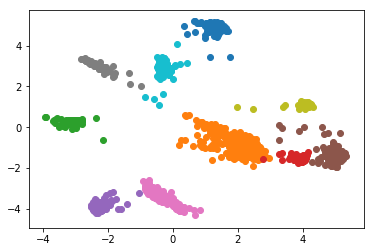

In [21]:

for idx, s in selected_segs.iloc[::10].iterrows():
    usub = umis.groupby("seg").get_group(idx)    
    plt.scatter(usub.x, usub.y)
    


In [66]:
selected_segs["center_x"] = selected_umis.groupby("seg").x.mean()
selected_segs["center_y"] = selected_umis.groupby("seg").y.mean()


selected_umis["xdist"] = selected_umis.apply(lambda u: u.x - selected_segs.loc[u.seg].center_x, axis= 1)
selected_umis["ydist"] = selected_umis.apply(lambda u: u.y - selected_segs.loc[u.seg].center_y, axis= 1)
selected_umis["dist"] = selected_umis.apply(lambda u: (u.ydist**2 +u.xdist**2)**.5, axis= 1)
selected_umis["thresh_dist"] = selected_umis.apply(lambda u: np.min([(u.ydist**2 +u.xdist**2)**.5,.25]), axis= 1)


full_sel_umis = sq(Umi).filter(Umi.id.in_([int(v) for v in selected_umis.index.values])).all()



In [39]:
sel_ids = [int(v) for v in selected_umis.index.values]

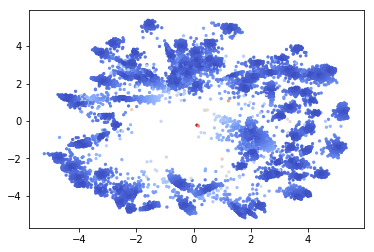

In [25]:
plt.scatter(selected_umis.x,selected_umis.y,s=5, c= selected_umis.dist*20, cmap=plt.cm.coolwarm)

In [62]:
full_sel_umis = sq(Umi).filter(Umi.id.in_([int(v) for v in selected_umis.index.values])).all()


In [67]:
for u in full_sel_umis:
    for n in ncbi_searches:
        selected_umis.at[u.id,n]= len([gt for gt in u.genes if n in gt.desc.lower()])



In [82]:
for n in ncbi_searches:
    print(n)
    selected_umis["gt_"+n] = 0
    outcomes = sq(Umi.id,func.count("*")).filter(Umi.id.in_(sel_ids))\
            .join(UmiGoTerm).join(GoTerm).filter(GoTerm.go_name.ilike(f"%{n}%")).group_by(Umi.id).all()
        
    for o in outcomes: 
        selected_umis.at[o[0],"gt_"+n]=o[1]




dna
ribo
nucle
memb
mitoc
cytop


In [ ]:
plt.style.use('seaborn-deep')

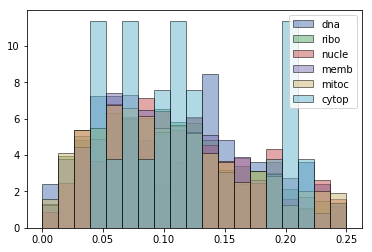

In [84]:

bins = np.linspace(0,.25,20)
for nm in ncbi_searches:
    #plt.scatter(selected_umis["dist"], selected_umis[nm])
    plt.hist(selected_umis.loc[(selected_umis.thresh_dist<.25) & (selected_umis[nm]> 0 )].thresh_dist,density=True, bins = bins, label = nm,alpha = .5,edgecolor="k")
plt.legend()

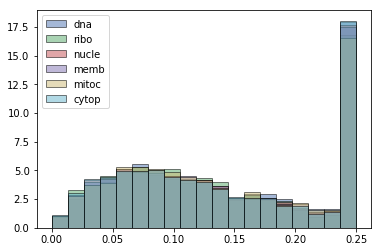

In [87]:

bins = np.linspace(0,.25,20)
for nm in ncbi_searches:
    #plt.scatter(selected_umis["dist"], selected_umis[nm])
    plt.hist(selected_umis.loc[ (selected_umis["gt_"+nm]> 0 )].thresh_dist,density=True, bins = bins, label = nm,alpha = .5,edgecolor="k")
plt.legend()